In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Introduction

This notebook is for this kaggle competition https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
The github link is https://github.com/HuanLi1008/kaggle_competition_Huan/blob/develop/house_price_predict_Huan.ipynb

## Problem

Every home buyer dreams to have superpower of predicting hourse price. This project is trying to build a supervised learning model to predict house price. The reason of supervised learning is helpful here is our model needs labeled data to learn how the house price related with possible features.


Our goal is predicted result as close to groud truth as possible. In this notebook, I will use Root-Mean-Squared-Error(RMSE) to evaluate how good our model performed. Predicting house price is a typical regression problem, and there are many tools to help us achive our goal, like linear regression, random forest, Gredient Boosting.etc. We will try a few different models and tune hyperparameters, hopefully we will find a relatively good model.

## Data

The data is from kaggle competition https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

The data contains 4 files: train.csv, test.csv, data_description.txt, sample_submission.csv.
* train.csv - the training set with shape of (1460 * 81)
* test.csv - the test set with shape of (1459 * 80)
* data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
* sample_submission.csv - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

# Exploratory Data Analysis (EDA)

## Load Data

In [103]:
in_dir = '/kaggle/input/house-prices-advanced-regression-techniques'
train_df = pd.read_csv(in_dir + '/train.csv')
test_df = pd.read_csv(in_dir + '/test.csv')


## Inspect Data And Explore Data

In [41]:
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [54]:
print(f'The shape of train_df is {train_df.shape}')

The shape of train_df is (1460, 81)


In [5]:
test_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [55]:
print(f'The shape of test_df is {test_df.shape}')

The shape of test_df is (1459, 80)


Test dataset doesn't contains "SalePrice" column whereas the train dataset contains "SalePrice"

In [52]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
features = test_df.columns
features

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Clean Data



Drop "Id" frist, since id is not a meaningful column, and our model can not learn anything from id.

In [104]:
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

### Check Missing Value

In [105]:
total = train_df.isnull().sum().sort_values(ascending=False)
percentage = round((train_df.isnull().sum()/train_df.isnull().count()),4).sort_values(ascending=False)

missing_data = pd.concat([total,percentage],axis=1, keys=['Missing Count', 'Percentage'])
missing_data = missing_data[missing_data['Missing Count'] > 0]
missing_data.shape

(19, 2)

In [23]:
missing_data.head(20)

,Missing Count,Percentage
PoolQC,1453,0.9952
MiscFeature,1406,0.9630
Alley,1369,0.9377
Fence,1179,0.8075
MasVnrType,872,0.5973
FireplaceQu,690,0.4726
LotFrontage,259,0.1774
GarageYrBlt,81,0.0555
GarageCond,81,0.0555
GarageType,81,0.0555


### Handle Missing Values

If the percentage of missing value of a column is greater than 10%, I will drop the whole column. For example, the column "PoolQC" miss 99% values, there is no need to impute data for this column. For the rest columns, I will impute median of the column for numerical columns, and fill None for categorial columns.

In [106]:
train_df.drop(missing_data[missing_data['Percentage'] > 0.1].index, axis=1, inplace=True)
test_df.drop(missing_data[missing_data['Percentage'] > 0.1].index, axis=1, inplace=True)
print(train_df.shape)
print(test_df.shape)

(1460, 73)
(1459, 72)


In [107]:
for col in missing_data[missing_data['Percentage'] <= 0.1].index:
    if train_df[col].dtype == 'object':
        train_df[col].fillna("None", inplace=True)
        
    else:
        train_df[col].fillna(train_df[col].median(), inplace=True)
        
print(train_df.isnull().sum().sort_values(ascending=False)[:5])


MSSubClass    0
CentralAir    0
GarageType    0
Fireplaces    0
Functional    0
dtype: int64


In [108]:
print(train_df.shape)
print(test_df.shape)

(1460, 73)
(1459, 72)


Check duplicates

In [8]:
train_df[train_df.duplicated()]

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [9]:
test_df[test_df.duplicated()]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition


There is no duplicates.

Summary:

* Drop column "Id" as this's not so meaningful
* Handle missing value, if one column has more than 10% missing value, drop the whole column, else either fill with median value or fill with None.
* Check duplicates.



## Explore Data

Since we have so many features, now let's divide our features into numerical and catagorical.

In [62]:
features = test_df.columns
print(len(features))

72


In [63]:
numerical_features = []
categorical_features = []
for feature in features:
    if train_df[feature].dtype == "object":
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)
print(len(numerical_features))
print(len(categorical_features))

35
37


In [12]:
print(numerical_features)

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [13]:
print(categorical_features)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


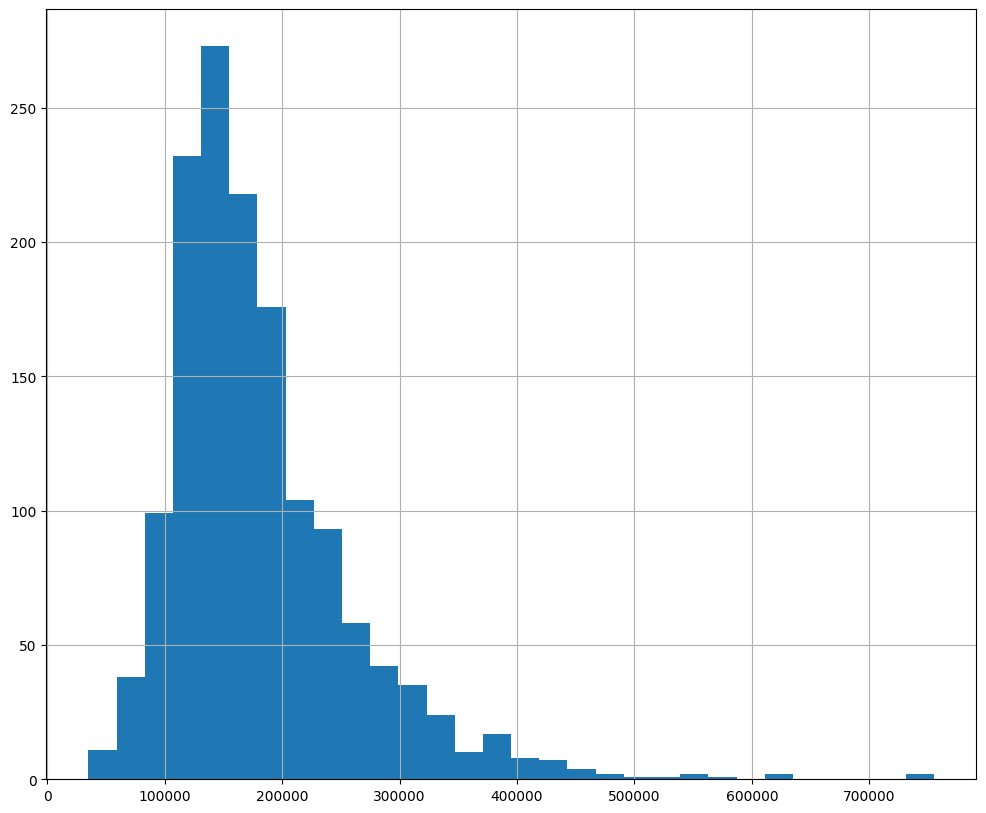

In [14]:
# sns.histplot(train_df['SalePrice'], kde=True);
train_df["SalePrice"].hist(bins=30, figsize=(12, 10))
plt.show()

Disturbution of some numerical features

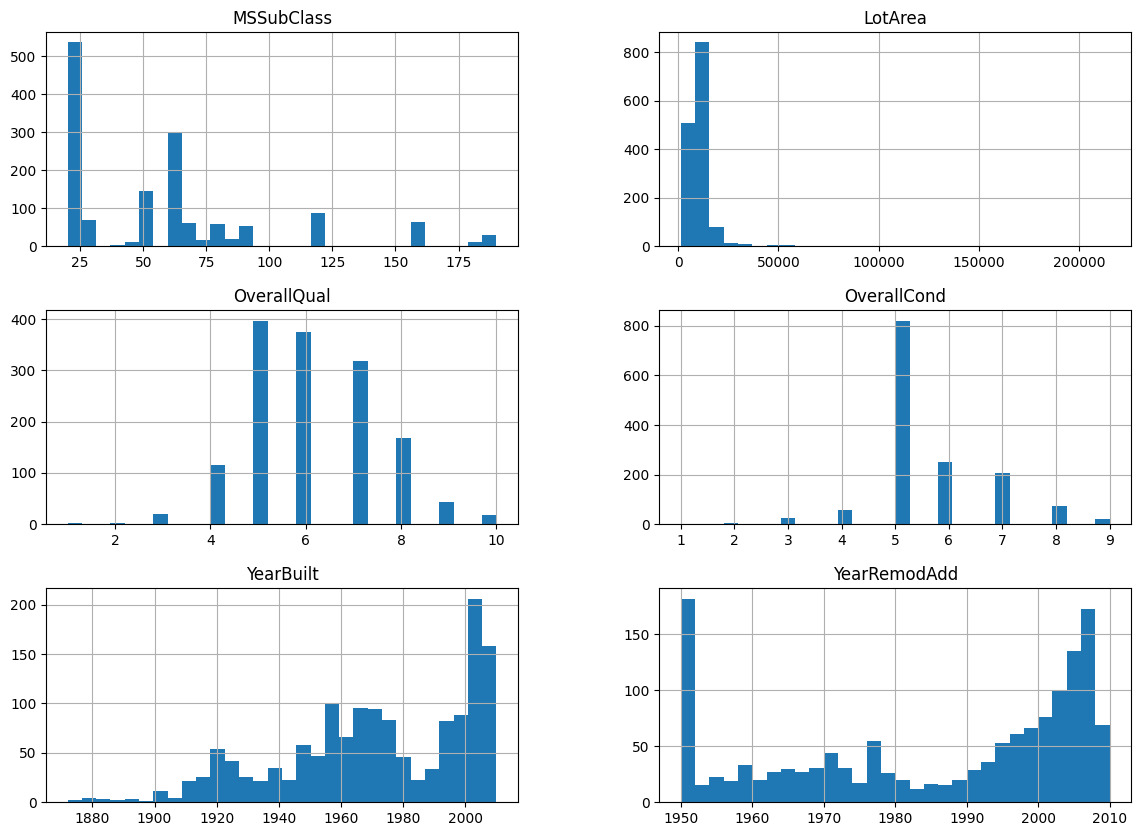

In [15]:
some_numerical_features = numerical_features[:6]
train_df[some_numerical_features].hist(bins=30, figsize=(14, 10))
plt.show()

Relationship of numerical features VS salePrice

As there are 35 numberical features, I will devide them to 3 plots

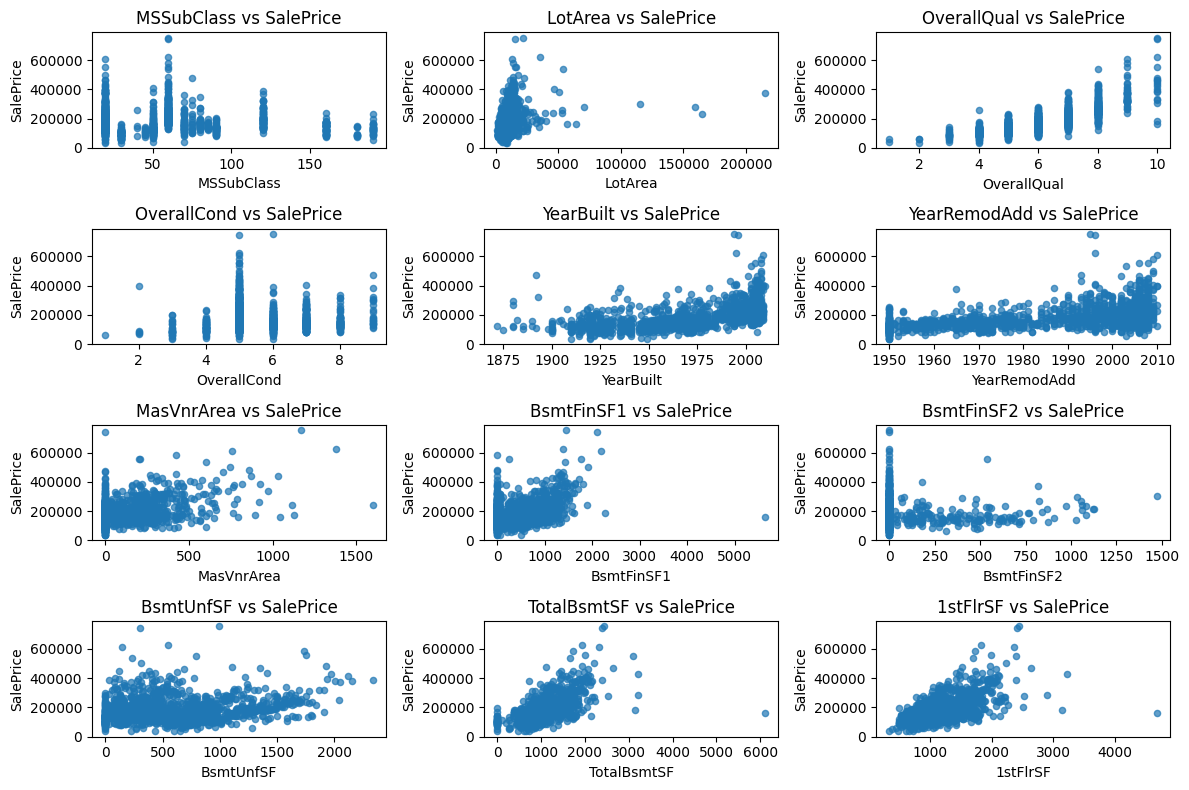

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8)) 
axes = axes.flatten() 
for i, feature in enumerate(numerical_features[:12]):
    train_df.plot.scatter(x=feature, y='SalePrice', ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{feature} vs SalePrice')

plt.tight_layout()
plt.show()


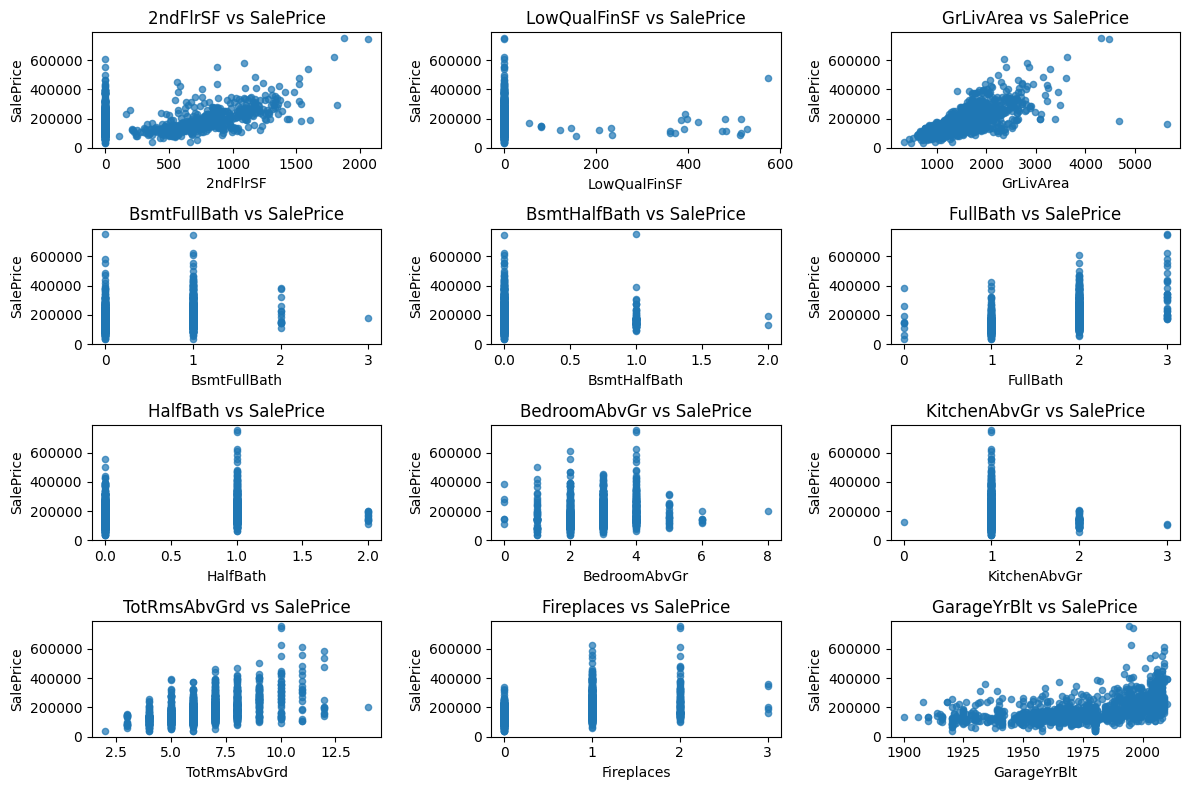

In [17]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8)) 
axes = axes.flatten() 
for i, feature in enumerate(numerical_features[12:24]):
    train_df.plot.scatter(x=feature, y='SalePrice', ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{feature} vs SalePrice')

plt.tight_layout()
plt.show()

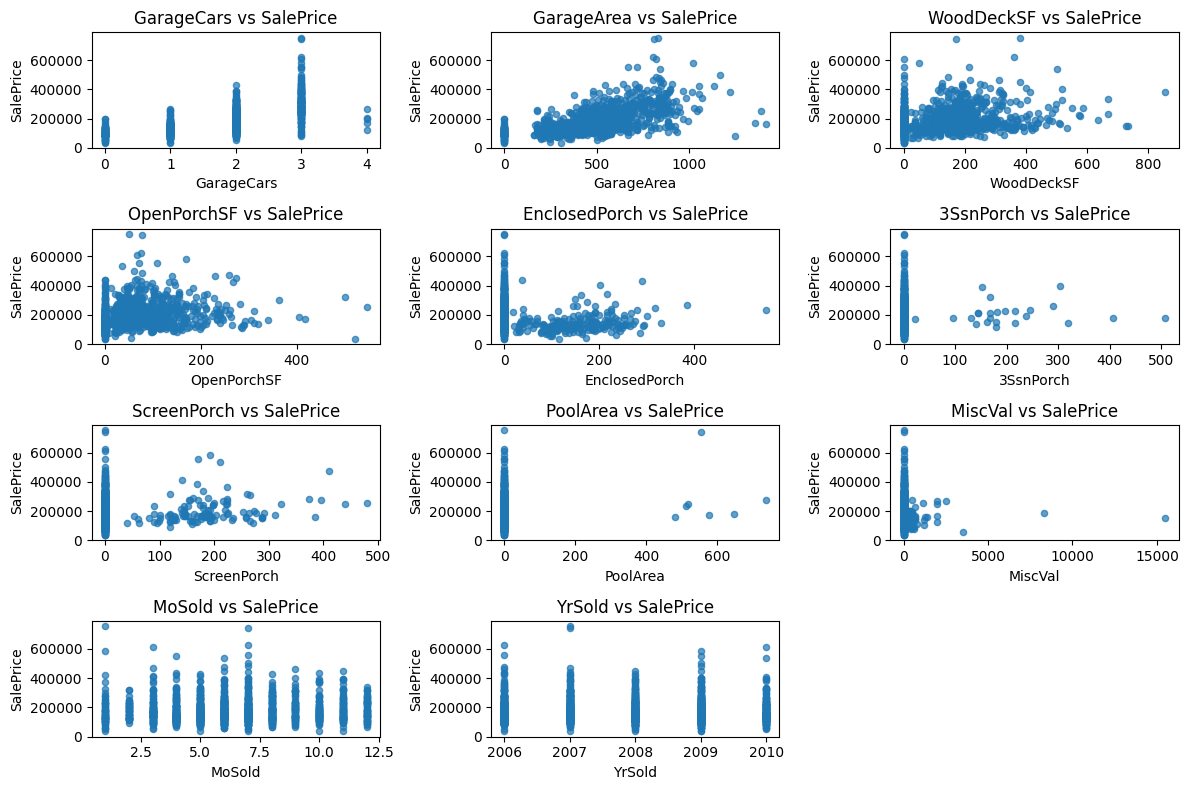

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8)) 
axes = axes.flatten() 
for i, feature in enumerate(numerical_features[24:]):
    train_df.plot.scatter(x=feature, y='SalePrice', ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{feature} vs SalePrice')
for i in range(11, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

There are some linearity can be observed, like "GrLivArea", "1stFlrSF" and "TotalBsmtSF"


Categorical Features

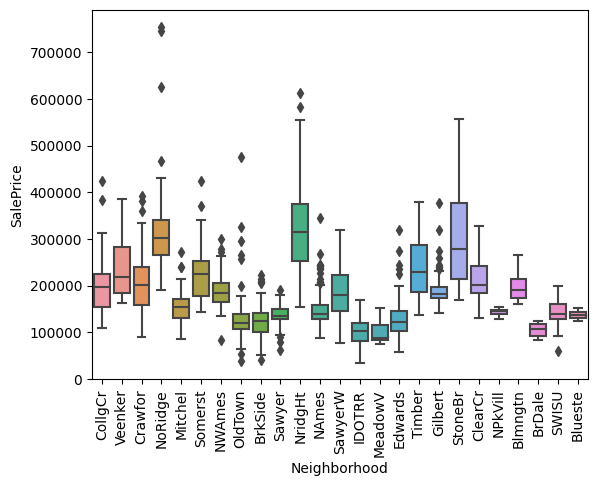

In [20]:
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df)
plt.xticks(rotation=90)
plt.show()

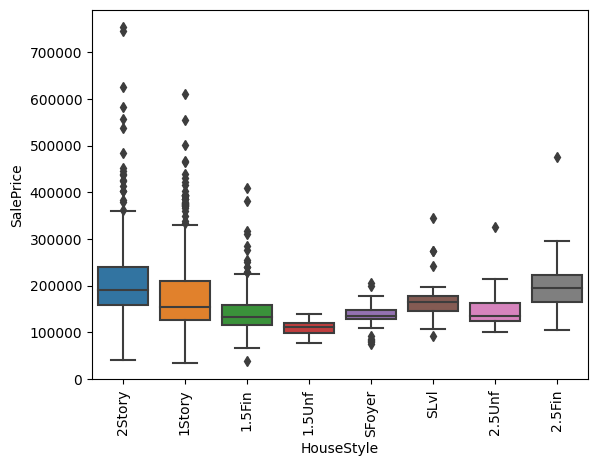

In [44]:
sns.boxplot(x='HouseStyle', y='SalePrice', data=train_df)
plt.xticks(rotation=90)
plt.show()

Converting Categorical Features before we draw coorelation matrix

In [109]:
# One-hot encoding
train_df = pd.get_dummies(train_df, drop_first=True)


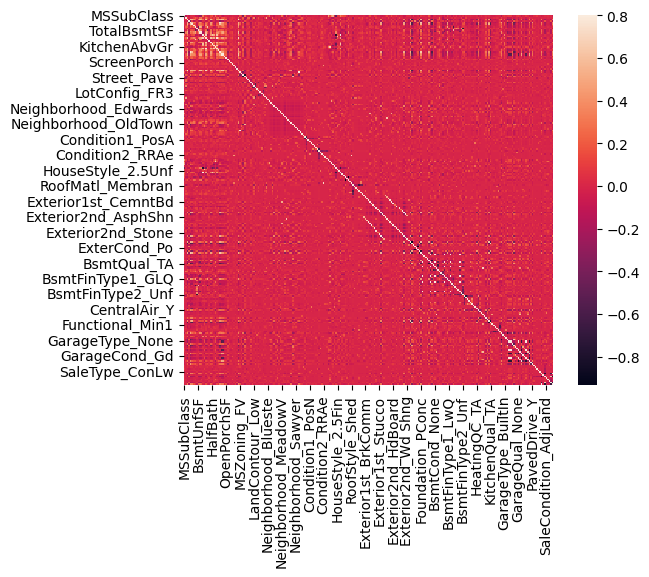

In [22]:
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, vmax=.8, square=True)
plt.show()


We have too many features to draw a correalation matrix, now let's focus on features are highly related to sale price.

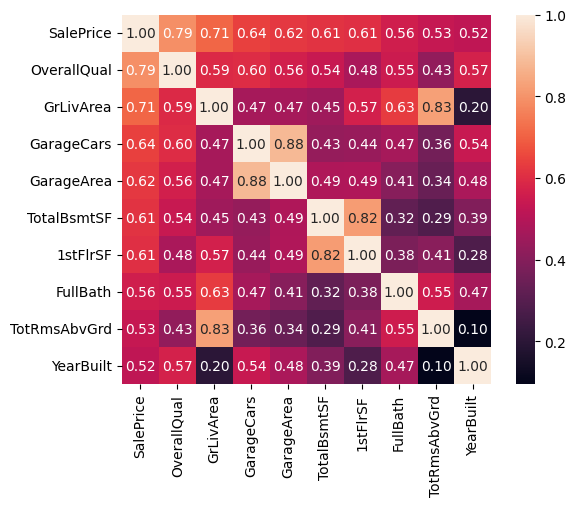

In [23]:
k = 10 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
# sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Summary: 
* features are highly related to sale price are [OverallQual, GrliveArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt]
* The relationships of "GrLivArea" VS "SalePrice", "1stFlrSF" VS "SalePrice" and "TotalBsmtSF" VS "SalePrice" are linear.

# Model

Feature Engineer
* Add more features, useing year sold and year built to get house age, year sold and year remod added to get remod age, using first floor SF + second floor SF + total basement SF to get totalSF

In [112]:
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
train_df['TotalSF'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['TotalBsmtSF']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']
test_df['TotalSF'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['TotalBsmtSF']

## Base Model

In [113]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


In [114]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1022, 241) (1022,)
(438, 241) (438,)


In [27]:
def rmse(y_true, y_predict):
    return np.sqrt(mse(y_true, y_predict))

In [28]:
def prediction_plot(y_true, y_pred):
    sns.scatterplot(x=y_true,y=y_true,label='real')
    sns.scatterplot(x=y_pred,y=y_true, label='pred')
    plt.title('Prediction Data Train')
    plt.legend()
    plt.show()

In [29]:
results = []

Loss of linear regression is 43960.14432935433


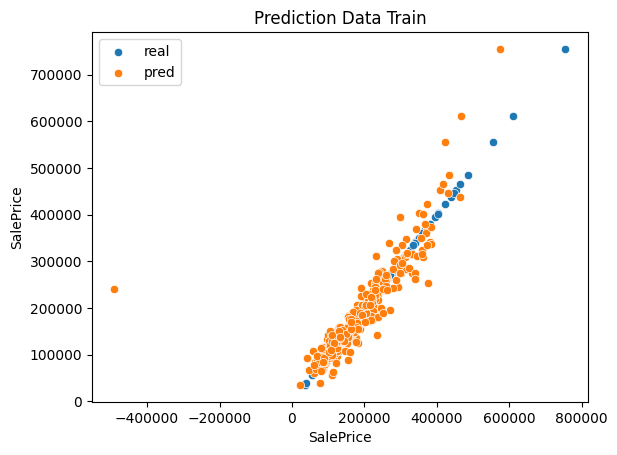

In [30]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)
lr_loss = rmse(y_val, lr_pred)
print(f'Loss of linear regression is {lr_loss}')
prediction_plot(y_val, lr_pred)

In [31]:
results.append({"Model Name": "Linear Regression", "Loss": lr_loss})
print(results)

[{'Model Name': 'Linear Regression', 'Loss': 43960.14432935433}]


Loss of random forest is 26387.222680497216


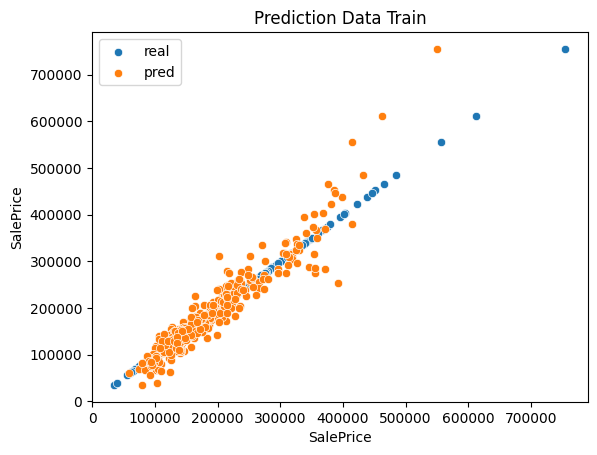

In [32]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rf_loss = rmse(y_val, rf_pred)
print(f'Loss of random forest is {rf_loss}')
prediction_plot(y_val, rf_pred)

In [33]:
results.append({"Model Name": "Base Random Forest", "Loss": rf_loss})
print(results)

[{'Model Name': 'Linear Regression', 'Loss': 43960.14432935433}, {'Model Name': 'Base Random Forest', 'Loss': 26387.222680497216}]


## Improve Model

### Hyperparameter Tuning

In [34]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


Best rf model loss: 26118.475827494898


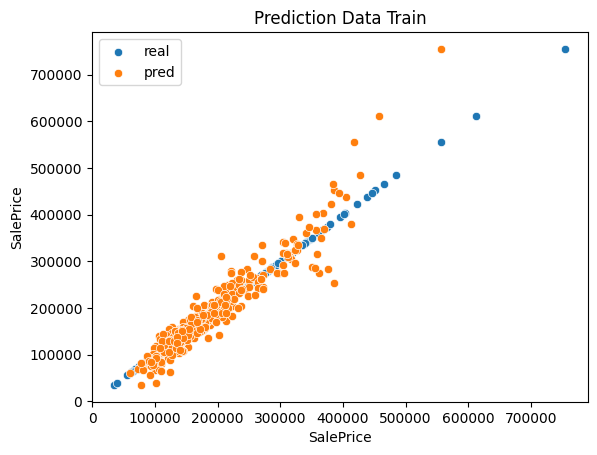

In [35]:
best_rf_model = grid_search.best_estimator_
best_rf_pred = best_rf_model.predict(X_val)
best_rf_loss = rmse(y_val, best_rf_pred)
print(f'Best rf model loss: {best_rf_loss}')
prediction_plot(y_val, best_rf_pred)

In [36]:
results.append({"Model Name": "Best Random Forest", "Loss": best_rf_loss})
print(results)

[{'Model Name': 'Linear Regression', 'Loss': 43960.14432935433}, {'Model Name': 'Base Random Forest', 'Loss': 26387.222680497216}, {'Model Name': 'Best Random Forest', 'Loss': 26118.475827494898}]


More complex model

Gradient Boosting model loss: 25955.68252426395


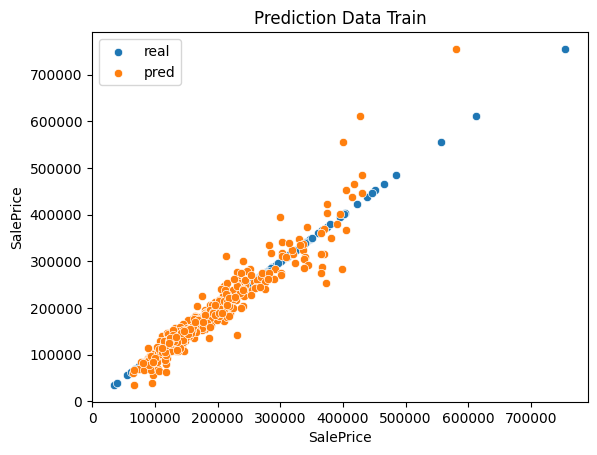

In [37]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_val)
gb_loss = rmse(y_val, gb_pred)
print(f'Gradient Boosting model loss: {gb_loss}')
prediction_plot(y_val, gb_pred)

In [38]:
results.append({"Model Name": "Gradient Boosting", "Loss": gb_loss})
print(results)

[{'Model Name': 'Linear Regression', 'Loss': 43960.14432935433}, {'Model Name': 'Base Random Forest', 'Loss': 26387.222680497216}, {'Model Name': 'Best Random Forest', 'Loss': 26118.475827494898}, {'Model Name': 'Gradient Boosting', 'Loss': 25955.68252426395}]


Grid search to find best parameter for gradient boosting

In [39]:
%%time
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
  # 'subsample': [0.6, 0.8, 1.0],
}

gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters: {gb_grid_search.best_params_}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
CPU times: user 1.62 s, sys: 133 ms, total: 1.75 s
Wall time: 1min


Best gb model loss: 25725.81702597068


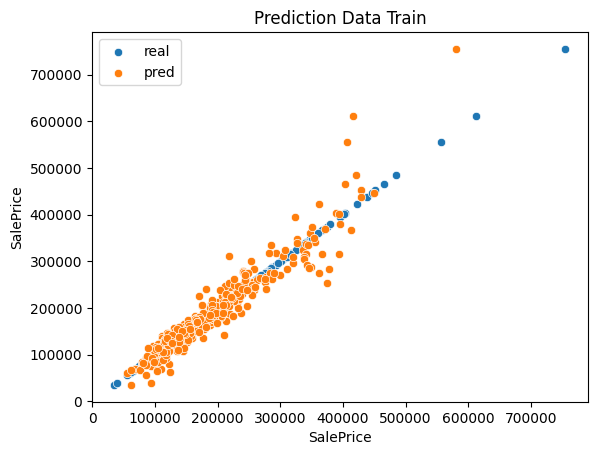

In [40]:
best_gb_model = gb_grid_search.best_estimator_
best_gb_pred = best_gb_model.predict(X_val)
best_gb_loss = rmse(y_val, best_gb_pred)
print(f'Best gb model loss: {best_gb_loss}')
prediction_plot(y_val, best_gb_pred)

In [41]:
results.append({"Model Name": "Best Gradient Boosting", "Loss": best_gb_loss})
print(results)

[{'Model Name': 'Linear Regression', 'Loss': 43960.14432935433}, {'Model Name': 'Base Random Forest', 'Loss': 26387.222680497216}, {'Model Name': 'Best Random Forest', 'Loss': 26118.475827494898}, {'Model Name': 'Gradient Boosting', 'Loss': 25955.68252426395}, {'Model Name': 'Best Gradient Boosting', 'Loss': 25725.81702597068}]


In [124]:
importances = best_gb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df[:10])

         Feature  Importance
240      TotalSF    0.390045
2    OverallQual    0.331741
4      YearBuilt    0.035720
24    GarageCars    0.029417
12      2ndFlrSF    0.027308
7     BsmtFinSF1    0.026956
14     GrLivArea    0.021456
1        LotArea    0.016163
22    Fireplaces    0.009090
30   ScreenPorch    0.008014


Above features are top 10 important features for predicting house price.

# Results and Analysis

In [42]:
results_df = pd.DataFrame(results)
results_df

,Model Name,Loss
0,Linear Regression,43960.144329
1,Base Random Forest,26387.222680
2,Best Random Forest,26118.475827
3,Gradient Boosting,25955.682524
4,Best Gradient Boosting,25725.817026


**We can see the complex model outperform the simple model, so random forest performs better than linear regression, and gradient boosting performs slightly better than random forest. We also ulitize grid search to find best hyperparameters for random forest and gradient boosting. Interestingly, the best random forest model only improved the base random forest very little, the same thing also happen to gradient boosting. I guess our data size might be a reason. Our train data only have 1022 data points. Small amount of data might cause a complex model overfit very soon.**

### Submit final model

Prepare test_df first. Fill missing value and convert catagorical features to numerical like we did to train_df bdefore.

In [115]:
missing_data_test = test_df.isnull().sum().sort_values(ascending=False)
print(missing_data_test)

GarageCond      78
GarageYrBlt     78
GarageFinish    78
GarageQual      78
GarageType      76
                ..
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
CentralAir       0
Length: 75, dtype: int64


In [116]:
for col in missing_data_test[missing_data_test>0].index:
    if test_df[col].dtype == 'object':
        test_df[col].fillna("None", inplace=True)        
    else:
        test_df[col].fillna(test_df[col].median(), inplace=True)
test_df.isnull().sum().sort_values(ascending=False)[:5]     
       

MSSubClass     0
GarageCars     0
GarageYrBlt    0
GarageType     0
Fireplaces     0
dtype: int64

In [117]:
# One-hot encoding
# one hot encoding might cause different amount of columns, so we need to align our test_df with train_df
test_df = pd.get_dummies(test_df, drop_first=True)
X, test_df = X.align(test_df, join='left', axis=1)
test_df.fillna(0, inplace=True)
test_df.shape

(1459, 241)

In [118]:
print(X.shape)
print(test_df.shape)

(1460, 241)
(1459, 241)


In [119]:
final_model = best_gb_model

In [120]:
final_prediction = final_model.predict(test_df)
final_prediction[:10]

array([125730.30940248, 160986.67359219, 185723.94800048, 181261.32180473,
       179403.38664497, 173813.62015705, 177938.45694428, 170083.78626413,
       184583.81673373, 124642.18343849])

In [121]:
submission = pd.read_csv(in_dir + '/sample_submission.csv')
submission['SalePrice'] = final_prediction

In [100]:
submission.head(5)

,Id,SalePrice
0,1461,125730.309402
1,1462,160986.673592
2,1463,185723.948000
3,1464,181261.321805
4,1465,179403.386645


In [122]:
submission.to_csv('submission.csv',index=False)

The best gradient boosting model give us the final loss: 13851

# Conclusion 

In this notebook, we try to build a supervised learning model to predict house price. 

For data cleaning and exploratory, we droped unmeaningful columns and missing too much values column. We also impute missing values with median number for numerical features and none for categorical features. To better learn categorical features, we used one hot encoder to encode the categorical features. We explored the relationship of features and target(price) by using scatter plot and correlation matrix. 

For models training, we first try linear regression and random forest as the baseline. Then we tried more complex model gradient boosting. For models with hyperparameters, we use grid search to find the best parameters.

The key takeaway of this project:
* The true relationship of this problem is close to linear, all linear regression model works good.
* Before we reach overfitting spot, the more complex the model is, the less likely the model be underfitting. That's why the random forest and gradient boosting outperform linear regression.
* Though this problem, we haven't observed the overfitting, we still need to consider regularization and cross validation to prevent overfitting.

Future improvement:
* Data size: our problem only have over 1000 data points which is not too much for machine learning. If it's possible, collecting more data will improved our model's performance.
* Data clean: in this notebook, we only apply basic data clean. In the future, more delicated data cleaning, like numerical feature scaling, and detect outliner will also be helpful for our model.
* Feature engineer: we only apply very basic feature engineer, like add all square feet of basement, square feet of first floor, and square feet of second floor into a new column called "TotalSF". More careful feature engineer will help our model learn data better and perform better.

# Reference

* https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://www.kaggle.com/code/fouedayedi/introtomlnotebook
* https://www.kaggle.com/code/darwinberrio/house-predict-boston#MODEL-SUPERVISED-(LINEAR-REGRESSION)